# Analysis using tSNE

''' Created on Thru 11 Jun 2020'''


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
import scipy
from sklearn.manifold import TSNE
cmap = cm.jet

In [29]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165          ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 100 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 1           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                ## value of resampling

session_now = 2
period = 10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [30]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_normed/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/tSNE/'

In [31]:
# define all relevant files names
session = session_now
file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{100}' + \
                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                      f'{component_evaluation_v}' + '.' + f'{registration_v}' + '.npy'
time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                      '.' + f'{0}' + '.pkl'
beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_event_' + f'{re_sf}' + '.npy'

In [32]:
##load activity and timeline
activity = np.load(file_directory + file_name_session_1)
timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
timeline_info = pickle.load(timeline_file)
##normalize neural activity
timeline_1 = np.zeros(len(timeline_info) + 1)
for i in range(len(timeline_info)):
    timeline_1[i] = timeline_info[i][1]
timeline_1[len(timeline_info)] = activity.shape[1]
neural_activity1 = activity[1:,:]
##downsample neural activity
resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity1,
                                                                                    re_sf=re_sf)
## LOAD BEHAVIOUR
behaviour = np.load(behaviour_dir + beh_file_name_1)
#c = np.linspace(0, 20, len(behaviour))
reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
resample_timeline = timeline_1/re_sf

In [33]:
events_list = []
events_counter_list = []
events_time_starts = []
start_counter = 100
counter = 0
for i in range(resample_beh1.shape[0]):
    if resample_beh1[i] != start_counter:
        events_list.append(start_counter)
        events_counter_list.append(counter)
        events_time_starts.append(i)
        start_counter = resample_beh1[i]
        counter = 1
    else:
        counter = counter + 1


events = np.array(events_list)
events_counter = np.array(events_counter_list)
events_time = np.array(events_time_starts)

resting_activity = []
target = 0
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]   # convert to seconds
time = events_time[position_events]
i = 0
for event in events_duration:
    if event > period:
        resting_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i + 1

nonexploring_activity = []
target = 1
position_events = np.where(events == target)[0]
events_duration = events_counter[position_events]
time = events_time[position_events]
i = 0
for event in events_duration:
    if event > period:
        nonexploring_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i+1

exploring_activity = []
for target in [2,3,4,5]:
    position_events = np.where(events == target)[0]
    events_duration = events_counter[position_events]
    time = events_time[position_events]
    i = 0
    for event in events_duration:
        if event > period:
            exploring_activity.append(resample_neural_activity_mean[:,time[i]:time[i]+period])
    i = i+1

In [34]:
### sorted by position in segment only non cero neurons

# resting 
mean_over_trials = np.mean(resting_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_r = np.flip(np.argsort(mean_firing_rate))
resting = mean_over_trials[positions_r,:]
non_zero_positions_r = np.where(np.mean(resting,axis=1))
resting_non_zero = resting[non_zero_positions_r,:]
resting_non_zero = resting_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(resting_non_zero,axis=1))
resting_non_zero = resting_non_zero[time_sort,:]

positions1 = positions_r[np.where(mean_firing_rate[positions_r])]
resting_corr_matrix2 = stats.corr_matrix(neural_activity = resting_non_zero)

resting_matrix = np.zeros((positions1.shape[0],period*len(resting_activity)))
for i in range(len(resting_activity)):
    resting_matrix[:,i*period:(i+1)*period] = resting_activity[i][positions_r[time_sort],:]

# non exploration (running)
mean_over_trials = np.mean(nonexploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_ne = np.flip(np.argsort(mean_firing_rate))
nonexploring = mean_over_trials[positions_ne,:]
non_zero_positions_ne = np.where(np.mean(nonexploring,axis=1))
nonexploring_non_zero = nonexploring[non_zero_positions_ne,:]
nonexploring_non_zero = nonexploring_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(nonexploring_non_zero,axis=1))
nonexploring_non_zero = nonexploring_non_zero[time_sort,:]


positions2= positions_ne[np.where(mean_firing_rate[positions_ne])]
nonexploring_corr_matrix2 = stats.corr_matrix(neural_activity = nonexploring_non_zero)  

nonexploring_matrix= np.zeros((positions2.shape[0],period*len(nonexploring_activity)))
for i in range(len(nonexploring_activity)):
    nonexploring_matrix[:,i*period:(i+1)*period] = nonexploring_activity[i][positions_ne[time_sort],:]


# object exploration

mean_over_trials = np.mean(exploring_activity, axis= 0)
mean_firing_rate = np.mean(mean_over_trials, axis = 1)
positions_e = np.flip(np.argsort(mean_firing_rate))
exploring = mean_over_trials[positions_e,:]
non_zero_positions_e = np.where(np.mean(exploring,axis=1))
exploring_non_zero = exploring[non_zero_positions_e,:]
exploring_non_zero = exploring_non_zero[0,:,:]
time_sort = np.argsort(np.argmax(exploring_non_zero,axis=1))
exploring_non_zero = exploring_non_zero[time_sort,:]

positions3 = positions_e[np.where(mean_firing_rate[positions_e])]
exploring_corr_matrix2 = stats.corr_matrix(neural_activity = exploring_non_zero)  

exploring_matrix= np.zeros((positions3.shape[0],period*len(exploring_activity)))
for i in range(len(exploring_activity)):
    exploring_matrix[:,i*period:(i+1)*period] = exploring_activity[i][positions_e[time_sort],:]



In [35]:
n_components = 3

print(resting_matrix.shape)
resting_embedded = TSNE(n_components=n_components).fit_transform(resting_matrix.T)

print(nonexploring_matrix.shape)
nonexploring_embedded = TSNE(n_components=n_components).fit_transform(nonexploring_matrix.T)

print(exploring_matrix.shape)
exploring_embedded = TSNE(n_components=n_components).fit_transform(exploring_matrix.T)


(305, 200)
(306, 990)
(239, 670)


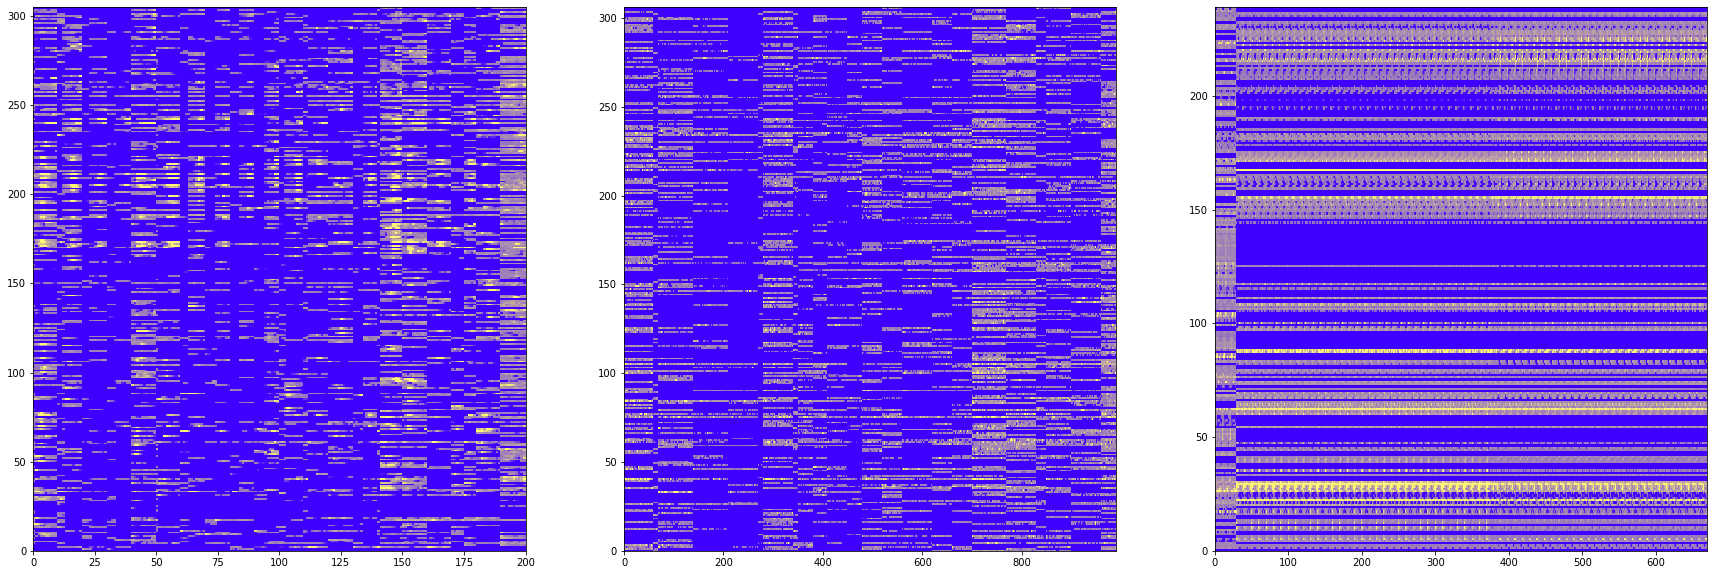

In [9]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


vmin = 0
vmax = 5
fig = plt.figure()
ax = fig.add_subplot(131)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(resting_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

ax = fig.add_subplot(132)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(nonexploring_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

ax = fig.add_subplot(133)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(exploring_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

fig.set_size_inches(30,10)

In [10]:
positions = np.where(resting_matrix.flatten())[0]
#print(positions[0].shape)
mean_value = np.mean(resting_matrix.flatten()[positions])
print(mean_value)
resting_matrix_new = resting_matrix.flatten()
positions_cero = np.where(resting_matrix.flatten() < mean_value/4)[0]
resting_matrix_new[positions_cero] = mean_value
print(np.min(resting_matrix_new.flatten()))
resting_matrix_new_matrix = np.reshape(resting_matrix_new, resting_matrix.shape)


positions = np.where(exploring_matrix.flatten())[0]
#print(positions[0].shape)
mean_value = np.mean(exploring_matrix.flatten()[positions])
print(mean_value)
exploring_matrix_new = exploring_matrix.flatten()
positions_cero = np.where(exploring_matrix.flatten() < mean_value/4)[0]
exploring_matrix_new[positions_cero] = mean_value
print(np.min(exploring_matrix_new.flatten()))
exploring_matrix_new_matrix = np.reshape(exploring_matrix_new, exploring_matrix.shape)

#figure, axes = plt.subplots(3,1)
#axes[0].hist(resting_matrix.flatten(), bins = np.arange(0,np.max(resting_matrix.flatten()),1/20))

1.102148566887253
0.27574698122010666
1.1209520167972569
0.28070537889358116


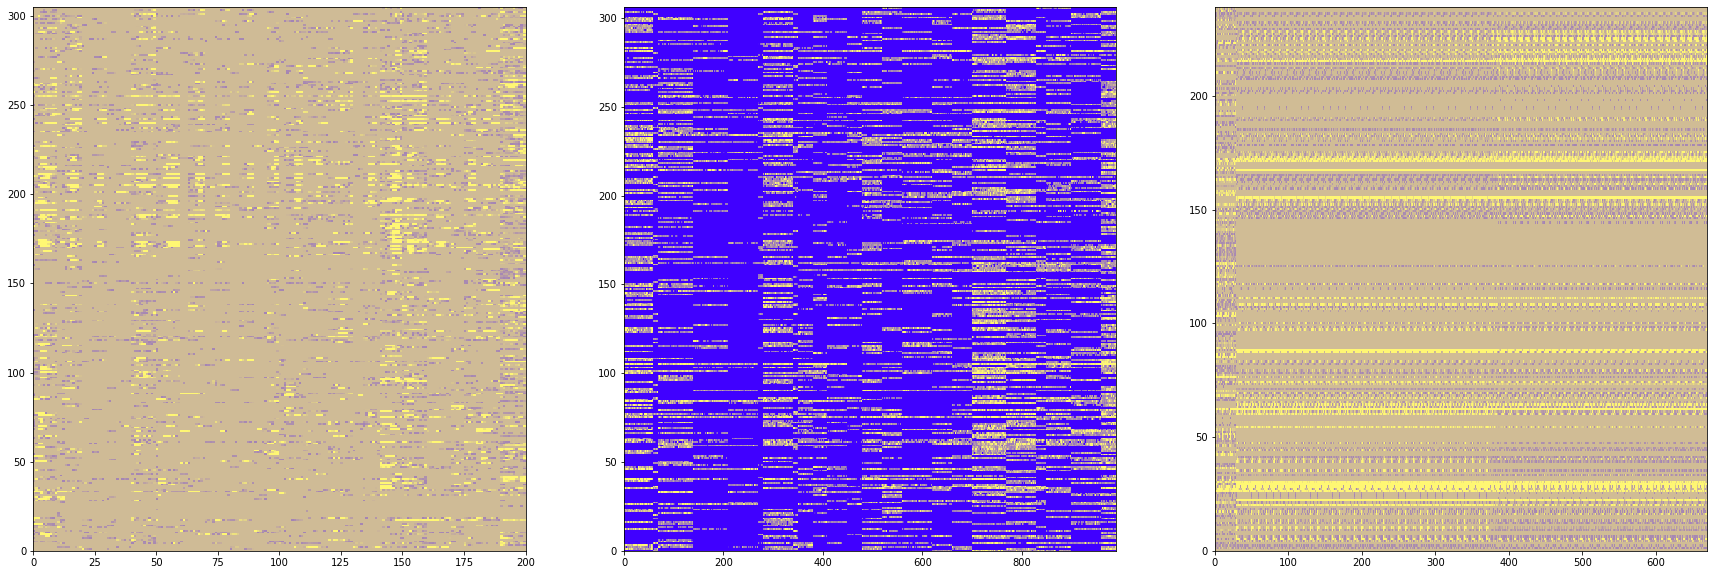

In [11]:

vmin = 0
vmax = 2
fig = plt.figure()
ax = fig.add_subplot(131)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(resting_matrix_new_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

ax = fig.add_subplot(132)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(nonexploring_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

ax = fig.add_subplot(133)
#ax.set_title('Resting:'+ f'{len(resting_activity)}' + 'Events' , fontsize = 15)
#ax.set_ylabel('Neurons', fontsize = 15)
#ax.set_xlabel('Time [s]', fontsize = 15)
mesh = ax.pcolormesh(exploring_matrix_new_matrix, cmap = cm)
mesh.set_clim(vmin,vmax)

fig.set_size_inches(30,10)

In [13]:
n_components = 2

print(resting_matrix_new_matrix.shape)
resting_embedded = TSNE(n_components=n_components).fit_transform(resting_matrix.T)

#print(nonexploring_matrix.shape)
#nonexploring_embedded = TSNE(n_components=n_components).fit_transform(nonexploring_matrix.T)

#print(exploring_matrix.shape)
exploring_embedded = TSNE(n_components=n_components).fit_transform(exploring_matrix_new_matrix.T)


(305, 200)


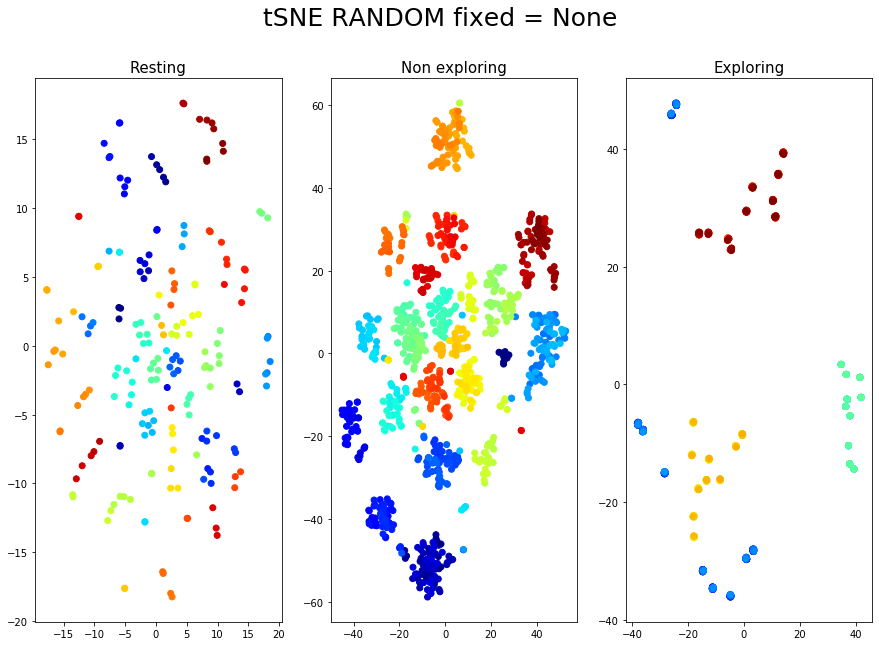

In [25]:
color1 = np.linspace(0, 20, resting_matrix.shape[1])
color2 = np.linspace(0, 20, nonexploring_matrix.shape[1])
color3 = np.linspace(0, 20, exploring_matrix.shape[1])

fig = plt.figure()
ax = fig.add_subplot(131)
ax.scatter(resting_embedded[:,0],resting_embedded[:,1], c=color1, cmap=cmap)
ax.set_title('Resting', fontsize = 15)
ax = fig.add_subplot(132)
ax.scatter(nonexploring_embedded[:,0],nonexploring_embedded[:,1], c=color2, cmap=cmap)
ax.set_title('Non exploring', fontsize = 15)
ax = fig.add_subplot(133)
ax.scatter(exploring_embedded[:,0],exploring_embedded[:,1], c=color3, cmap=cmap)
ax.set_title('Exploring', fontsize = 15)


fig.set_size_inches(15,10)

fig.suptitle('tSNE ' + task + ' fixed = ' + fixed   , fontsize = 25)
figure_name = figure_path + 'tSNE_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)


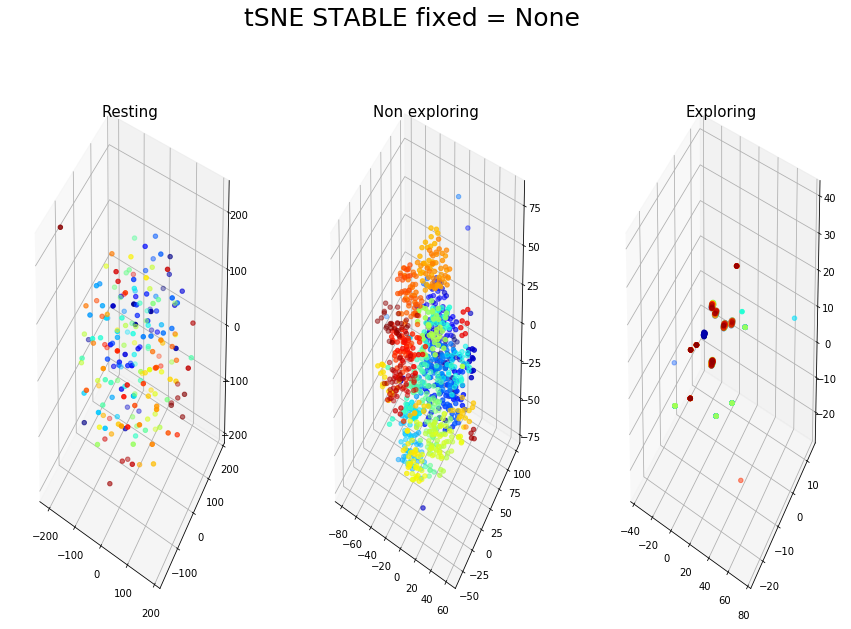

In [36]:
color1 = np.linspace(0, 20, resting_matrix.shape[1])
color2 = np.linspace(0, 20, nonexploring_matrix.shape[1])
color3 = np.linspace(0, 20, exploring_matrix.shape[1])

fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.scatter(resting_embedded[:,0],resting_embedded[:,1],resting_embedded[:,2], c=color1, cmap=cmap)
ax.set_title('Resting', fontsize = 15)
ax = fig.add_subplot(132, projection='3d')
ax.scatter(nonexploring_embedded[:,0],nonexploring_embedded[:,1],nonexploring_embedded[:,2], c=color2, cmap=cmap)
ax.set_title('Non exploring', fontsize = 15)
ax = fig.add_subplot(133, projection='3d')
ax.scatter(exploring_embedded[:,0],exploring_embedded[:,1],exploring_embedded[:,2], c=color3, cmap=cmap)
ax.set_title('Exploring', fontsize = 15)


fig.set_size_inches(15,10)

fig.suptitle('tSNE ' + task + ' fixed = ' + fixed   , fontsize = 25)
figure_name = figure_path + 'tSNE_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_3D.png'
fig.savefig(figure_name)
